In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
# sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph as sg
import dataprocess.data_handler_03 as dh

# Train the GLR model on the response of several cell groups

Groups are created using the pairwise interactions extracted from Ben Hoshal's maximum entropy model.

## Load and preprocess the data

In [3]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
binned_data = np.load(spikes_dp+'spikes.npy')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order = np.array([ 54,  35,  10,  60,  74,   9,  61,  56,  91, 104,  39,   7,  29,  68,  81,  41,  75 , 76,
   82,  79,  32,  51,  14,  88,  89,   8, 107,   3,  80,  55, 106,  96,  94, 95,   6,  20,
   83,  87,   1,  97, 103,  28,  18,  16,  85, 101,   2,  52,  11,  71, 108,  38,  25,  53,
  113,  64,  58,  24,  70,  43,  77,  45, 110,  49,  26,  40,  48,  67, 100,  30,  19,  36,
   17,   5,  69,  65,  99, 78,  33,  37,  47,  66,  59,  98,  21,  90,  12,  46,  86,  92,
    4, 112,  62,  50, 105,  27,  13,  93, 102,  63,  34,  31,  84,  23,  44,  15, 109, 111,
   72,  73,  42,  57,  22])
I_order = I_order - 1

In [4]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order[:10]:
    pers = dh.class_percentages(binned_data[:,:,neu_i].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f} %'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} % of data belongs to class 1'.format(avg_spike_perc))

total_perc = np.sum(binned_data == 1) * 100 / len(binned_data.reshape(-1))
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 53 | 0.44 %
neuron # 34 | 0.37 %
neuron #  9 | 0.64 %
neuron # 59 | 0.50 %
neuron # 73 | 0.78 %
neuron #  8 | 1.03 %
neuron # 60 | 1.42 %
neuron # 55 | 0.28 %
neuron # 90 | 0.29 %
neuron #103 | 0.97 %
---------------------------------------------
AVERAGE     | 0.67 % of data belongs to class 1
---------------------------------------------
3.00 % of the whole data belongs to class 1.


In [6]:
# load the cell groups from pickle file
# with open('cell_groups_ising.pkl', 'rb') as file:
#     cell_groups = pickle.load(file)
    
with open('cell_groups_rtpairwise.pkl', 'rb') as file:
    cell_groups = pickle.load(file)

num_groups = len(cell_groups)
print('number of cell groups:', num_groups)
print('group sizes:', [len(group) for group in cell_groups])

number of cell groups: 3
group sizes: [16, 13, 11]


In [5]:
# create the ORed response of each cell group
group_responses = []

for group in range(num_groups):
    group_resp = np.zeros((297, 1141, 1))
    for trial in range(297):
        for frame in range(1141):
            group_resp[trial, frame, :] = 2 * int((binned_data[trial, frame, cell_groups[group]] == 1).any()) - 1
    group_responses.append(group_resp)

In [6]:
# split the repeats into experiment and control groups
group_responses_exp = []
group_responses_cntr = []
for group in group_responses:
    group_responses_exp.append(group[::2, :, :])
    group_responses_cntr.append(group[1::2, :, :])

print('experiment:', len(group_responses_exp), group_responses_exp[0].shape)
print('control:', len(group_responses_cntr), group_responses_cntr[0].shape)

experiment: 3 (149, 1141, 1)
control: 3 (148, 1141, 1)


## Create the training and validation datasets

In [7]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]*10000

def transform_soenet(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp[0], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/soenet/soenet3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_soenet, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'soenet'}

In [8]:
train_num = 200
val_num = 50

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=0)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])
print('minimum value of train features: ', np.min(train_data['des']))
print('mean value of train features: ', np.mean(train_data['des']))
print('median value of train features: ', np.median(train_data['des']))
print('maximum value of train features: ', np.max(train_data['des']))

feature_id:  sift3d
train_num =  200 , val_num =  50
number of features:  77
train_smpls =  [1481 1279 1532 1881 1317 1726 1281 1793 1779 1665 1666 1873 1820 1695
 2002 1759 1765 1893 1673 1340 1947 2134 1748 1821 1771 2130 1463 1434
 2159 1350 1645 1754 1531 1441 1316 2111 1672 1788 1917 1869 1679 1774
 2259 1688 1802 1891 1908 2170 1419 1603 2128 1712 2149 1823 1514 1746
 2127 2080 1453 2198 1868 1739 2224 1396 2146 2125 1903 1900 1711 1610
 1803 1946 1144 1707 1309 1512 1756 2257 1335 1772 1422 1809 1871 1783
 2156 1817 1535 2115 1697 2126 1830 1805 1283 1184 1524 2165 1143 1361
 2145 1530 2097 1916 2092 1976 1601 1261 1156 1450 1741 1417 2049 2069
 1339 2218 2107 1578 1845 1247 1923 1591 1577 2188 1728 2213 1776 1179
 1175 1732 1613 1263 1348 1195 1377 1858 1248 2075 1649 1363 1359 1956
 1812 1580 2061 1491 2048 2000 1657 2037 1400 1581 1827 2070 2281 1269
 1777 2072 2055 1997 2220 1960 1376 1614 1198 2086 1847 1862 1993 1294
 2042 2233 1977 1165 1826 1197 1631 1644 1545 1217 1632 

## Train the GLR model (exp: 1st group)

In [9]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [10]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

10000


In [11]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_1, fact_stats_1 = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M_1 = fact_B_1.T @ fact_B_1
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 1.33e-02;  train loss (E) =  9.71
  15: eps = 5.80e-04;  train loss (E) =  0.20
  30: eps = 1.62e-03;  train loss (E) =  0.16
  45: eps = 2.27e-03;  train loss (E) =  0.16
  60: eps = 1.58e-03;  train loss (E) =  0.16
  75: eps = 1.11e-03;  train loss (E) =  0.16
  90: eps = 1.55e-03;  train loss (E) =  0.16
 105: eps = 2.16e-03;  train loss (E) =  0.16
 120: eps = 1.51e-03;  train loss (E) =  0.16
 135: eps = 1.06e-03;  train loss (E) =  0.16
 149: eps = 3.47e-03;  train loss (E) =  0.16
Elapsed  time: 58.060793 sec


In [12]:
# validate exp: 1st model
fact_val_acc_1, fact_y_est_1, fact_t_1 = sg.get_acc(fact_M_1, train_data['des'], train_data['lbls'], 
                                                    val_data['des'], val_data['lbls'], sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_1))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_1))

Elapsed time: 0.074834 sec
GLR val. acc. = 0.600000


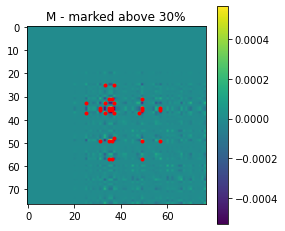

In [14]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_1, fig_params)

## Train the GLR model (exp: 2nd group)

In [15]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp[1], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_2 = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_2 = dh.update_set(val_data['smpls'], data_params)

In [16]:
val_lbls_2

array([ 1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.])

In [17]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_2, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

6519


In [18]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_2, fact_stats_2 = sg.fit_graph(train_data['des'], train_lbls_2, sg_params, gd_opt_params, seed)
fact_M_2 = fact_B_2.T @ fact_B_2
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.16
  15: eps = 2.32e-03;  train loss (E) =  0.06
  30: eps = 1.62e-03;  train loss (E) =  0.06
  45: eps = 1.13e-03;  train loss (E) =  0.05
  60: eps = 3.17e-03;  train loss (E) =  0.05
  75: eps = 1.11e-03;  train loss (E) =  0.05
  90: eps = 3.09e-03;  train loss (E) =  0.05
 105: eps = 2.16e-03;  train loss (E) =  0.05
 120: eps = 3.02e-03;  train loss (E) =  0.05
 135: eps = 1.06e-03;  train loss (E) =  0.05
 149: eps = 1.74e-03;  train loss (E) =  0.05
Elapsed  time: 38.677636 sec


In [18]:
# exp: 2nd model
fact_val_acc_2, fact_y_est_2, fact_t_2 = sg.get_acc(fact_M_2, train_data['des'], train_lbls_2, 
                                                    val_data['des'], val_lbls_2, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_2))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_2))

Elapsed time: 0.108707 sec
GLR val. acc. = 0.620000


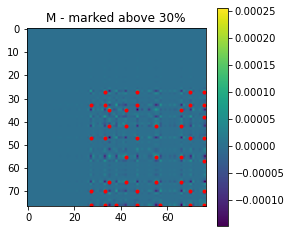

In [19]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

visualize_M(fact_M_2, fig_params)

## Train the GLR model (exp: 3rd group)

In [20]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_exp[2], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_3 = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_3 = dh.update_set(val_data['smpls'], data_params)

In [21]:
val_lbls_3

array([ 1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.])

In [22]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_3, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

7599


In [23]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_3, fact_stats_3 = sg.fit_graph(train_data['des'], train_lbls_3, sg_params, gd_opt_params, seed)
fact_M_3 = fact_B_3.T @ fact_B_3
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.15
  15: eps = 2.32e-03;  train loss (E) =  0.07
  30: eps = 1.62e-03;  train loss (E) =  0.06
  45: eps = 2.27e-03;  train loss (E) =  0.06
  60: eps = 1.58e-03;  train loss (E) =  0.06
  75: eps = 2.21e-03;  train loss (E) =  0.06
  90: eps = 1.55e-03;  train loss (E) =  0.06
 105: eps = 2.16e-03;  train loss (E) =  0.06
 120: eps = 1.51e-03;  train loss (E) =  0.06
 135: eps = 1.06e-03;  train loss (E) =  0.06
 149: eps = 1.74e-03;  train loss (E) =  0.06
Elapsed  time: 44.979736 sec


In [24]:
# exp: 3rd model
fact_val_acc_3, fact_y_est_3, fact_t_3 = sg.get_acc(fact_M_3, train_data['des'], train_lbls_3, 
                                                    val_data['des'], val_lbls_3, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_3))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_3))

Elapsed time: 0.086768 sec
GLR val. acc. = 0.780000


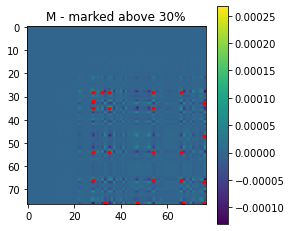

In [25]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_3, fig_params)

## Compare the three groups

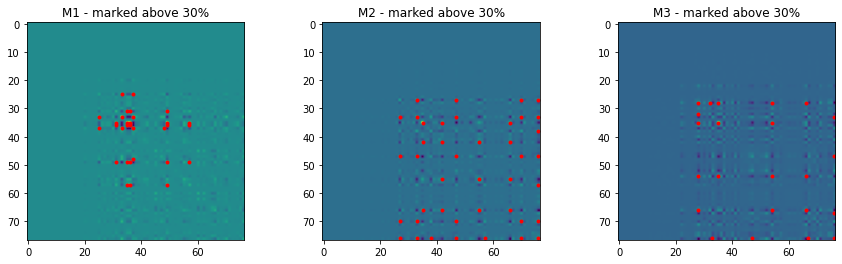

In [26]:
# print the optimized M
rmark_th = fig_params['rmark_th']
xloc = fig_params['xloc']
yloc = fig_params['yloc']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(fact_M_1)   
lim = (rmark_th/100) * np.max(fact_M_1) # marker threshold                
plt.plot(xloc[fact_M_1 > lim],yloc[fact_M_1 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M1 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,2)
plt.imshow(fact_M_2)
lim = (rmark_th/100) * np.max(fact_M_2) # marker threshold                
plt.plot(xloc[fact_M_2 > lim],yloc[fact_M_2 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M2 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,3)
plt.imshow(fact_M_3)
lim = (rmark_th/100) * np.max(fact_M_3) # marker threshold                
plt.plot(xloc[fact_M_3 > lim],yloc[fact_M_3 > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M3 - marked above {}%'.format(rmark_th))

plt.savefig('image/Ms.png',dpi=300, bbox_inches = "tight")

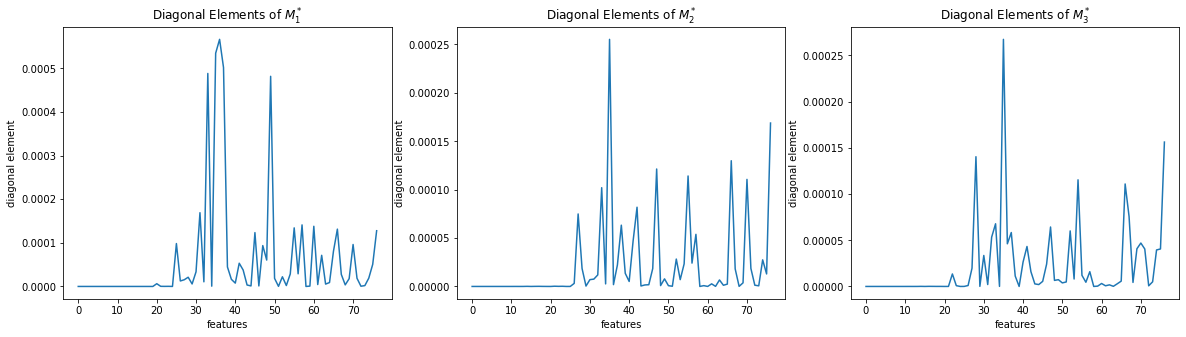

In [27]:
# print the diagonal elements of M
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(fact_M_1.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_1^*$')

plt.subplot(1,3,2)
plt.plot(fact_M_2.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_2^*$')

plt.subplot(1,3,3)
plt.plot(fact_M_3.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_3^*$')

plt.savefig('image/diagonals.png',dpi=300, bbox_inches = "tight")

The largest eigenvalues of M1:
 [3.24100683e-03 8.68790607e-04 3.35691668e-04 6.41748182e-05
 4.11397130e-05 1.40260452e-05 3.95379974e-06 5.68312556e-09
 3.24284973e-10 2.16185036e-13]
The largest eigenvalues of M2:
 [1.17416364e-03 3.15076744e-04 9.77849404e-05 2.85652663e-05
 1.05141246e-05 1.83994056e-06 7.60101818e-07 2.47740280e-07
 3.14604258e-09 1.03221144e-10]
The largest eigenvalues of M3:
 [1.16861532e-03 2.85288384e-04 2.02438623e-04 3.82530591e-05
 1.64505152e-05 2.73969768e-06 5.59349220e-07 5.28312680e-09
 2.42286861e-10 7.44189279e-12]


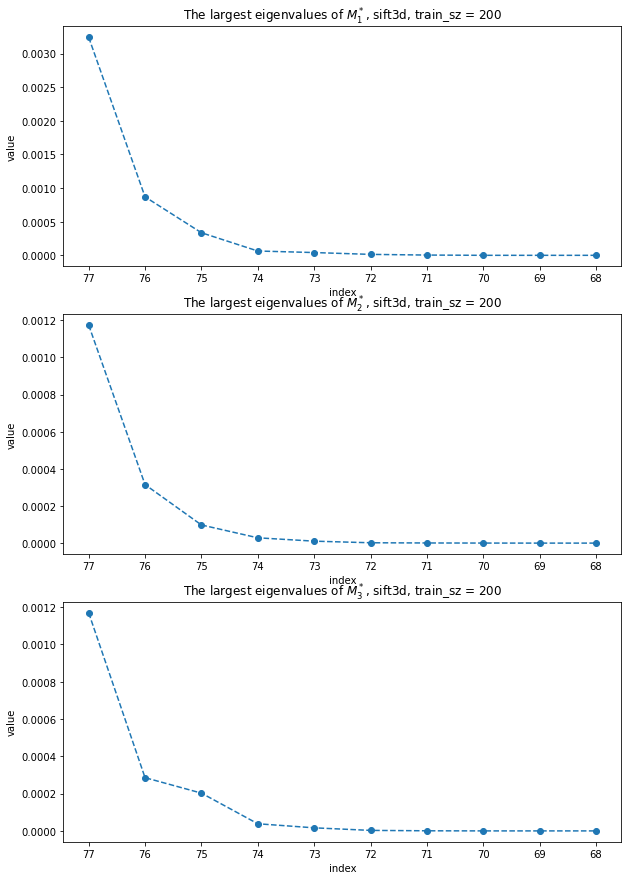

In [28]:
# print the eigenvalues
num_eig = 10
eigvals_1 = np.sort(np.real(np.linalg.eigvals(fact_M_1)))
eigvals_2 = np.sort(np.real(np.linalg.eigvals(fact_M_2)))
eigvals_3 = np.sort(np.real(np.linalg.eigvals(fact_M_3)))

print('The largest eigenvalues of M1:\n', eigvals_1[-1:-num_eig-1:-1])
print('The largest eigenvalues of M2:\n', eigvals_2[-1:-num_eig-1:-1])
print('The largest eigenvalues of M3:\n', eigvals_3[-1:-num_eig-1:-1])

x = eigvals_1.shape[0] - np.arange(num_eig)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(np.arange(num_eig), np.real(eigvals_1[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_1^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,2)
plt.plot(np.arange(num_eig), np.real(eigvals_2[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_2^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,3)
plt.plot(np.arange(num_eig), np.real(eigvals_3[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_3^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.savefig('image/eigvals.png',dpi=300, bbox_inches = "tight")

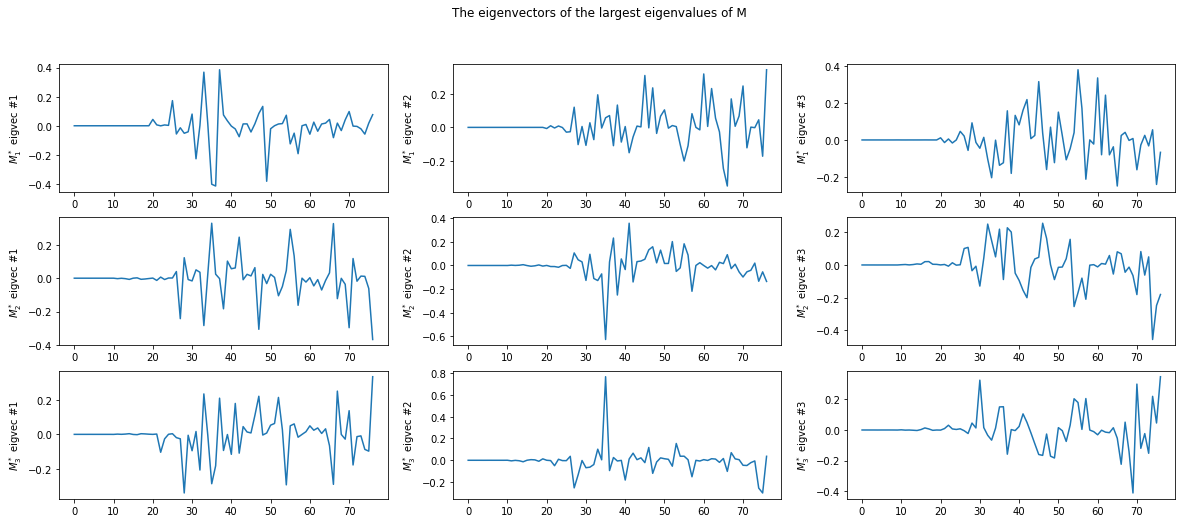

In [29]:
# plot the top eigenvectors for each cell group
num_eigvecs = 3
eigvals, eigvecs = np.linalg.eig(fact_M_1)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_1 = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_2)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_2 = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_3)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_3 = eigvecs[: ,maxeig_ind]

# plot the eigenvectors
xs = np.arange(maxeig_vecs_1.shape[0])
plt.figure(figsize=(20,8))
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,i+1)
    plt.plot(xs, np.real(maxeig_vecs_1[:,i]))
    plt.ylabel('$M_1^*$ eigvec #{}'.format(i+1))

for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_2[:,i]))
    plt.ylabel('$M_2^*$ eigvec #{}'.format(i+1))
    
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,2*num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_3[:,i]))
    plt.ylabel('$M_3^*$ eigvec #{}'.format(i+1))
    
_ = plt.suptitle('The eigenvectors of the largest eigenvalues of M')
plt.savefig('image/eigvecs.png',dpi=300, bbox_inches = "tight")

## Train for the control groups

In [30]:
similarity_1 = np.sum(group_responses_exp[0][:-1,:,:] == group_responses_cntr[0]) / group_responses_cntr[0].reshape(-1).shape[0]
print('The control group #1 is {:.2f}% similar to the experiment group'.format(similarity_1*100))

similarity_2 = np.sum(group_responses_exp[1][:-1,:,:] == group_responses_cntr[1]) / group_responses_cntr[1].reshape(-1).shape[0]
print('The control group #2 is {:.2f}% similar to the experiment group'.format(similarity_2*100))

similarity_3 = np.sum(group_responses_exp[2][:-1,:,:] == group_responses_cntr[2]) / group_responses_cntr[2].reshape(-1).shape[0]
print('The control group #3 is {:.2f}% similar to the experiment group'.format(similarity_3*100))

The control group #1 is 77.49% similar to the experiment group
The control group #2 is 83.20% similar to the experiment group
The control group #3 is 81.54% similar to the experiment group


## Train the GLR model (cntr: 1st group)

In [31]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr[0], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_1c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_1c = dh.update_set(val_data['smpls'], data_params)

In [32]:
val_lbls_1c

array([ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.])

In [33]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_1c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

8479


In [34]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_1c, fact_stats_1c = sg.fit_graph(train_data['des'], train_lbls_1c, sg_params, gd_opt_params, seed)
fact_M_1c = fact_B_1c.T @ fact_B_1c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 1.33e-02;  train loss (E) =  9.70
  15: eps = 2.32e-03;  train loss (E) =  0.21
  30: eps = 1.62e-03;  train loss (E) =  0.15
  45: eps = 2.27e-03;  train loss (E) =  0.15
  60: eps = 1.58e-03;  train loss (E) =  0.15
  75: eps = 2.21e-03;  train loss (E) =  0.15
  90: eps = 1.55e-03;  train loss (E) =  0.15
 105: eps = 2.16e-03;  train loss (E) =  0.15
 120: eps = 3.02e-03;  train loss (E) =  0.15
 135: eps = 2.11e-03;  train loss (E) =  0.15
 149: eps = 3.47e-03;  train loss (E) =  0.15
Elapsed  time: 50.374216 sec


In [35]:
# exp: 3rd model
fact_val_acc_1c, fact_y_est_1c, fact_t_1c = sg.get_acc(fact_M_1c, train_data['des'], train_lbls_1c, 
                                                    val_data['des'], val_lbls_1c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_1c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_1c))

Elapsed time: 0.099732 sec
GLR val. acc. = 0.600000


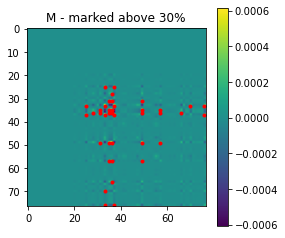

In [36]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_1c, fig_params)

## Train the GLR model (cntr: 2nd group)

In [37]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr[1], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_2c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_2c = dh.update_set(val_data['smpls'], data_params)

In [38]:
val_lbls_2c

array([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.])

In [39]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_2c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

7191


In [40]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_2c, fact_stats_2c = sg.fit_graph(train_data['des'], train_lbls_2c, sg_params, gd_opt_params, seed)
fact_M_2c = fact_B_2c.T @ fact_B_2c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.15
  15: eps = 2.32e-03;  train loss (E) =  0.06
  30: eps = 1.62e-03;  train loss (E) =  0.05
  45: eps = 2.27e-03;  train loss (E) =  0.05
  60: eps = 1.58e-03;  train loss (E) =  0.05
  75: eps = 2.21e-03;  train loss (E) =  0.05
  90: eps = 3.09e-03;  train loss (E) =  0.05
 105: eps = 1.08e-03;  train loss (E) =  0.05
 120: eps = 1.51e-03;  train loss (E) =  0.05
 135: eps = 2.11e-03;  train loss (E) =  0.05
 149: eps = 1.74e-03;  train loss (E) =  0.05
Elapsed  time: 43.831814 sec


In [41]:
# exp: 3rd model
fact_val_acc_2c, fact_y_est_2c, fact_t_2c = sg.get_acc(fact_M_2, train_data['des'], train_lbls_2c, 
                                                    val_data['des'], val_lbls_2c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_2c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_2c))

Elapsed time: 0.096740 sec
GLR val. acc. = 0.540000


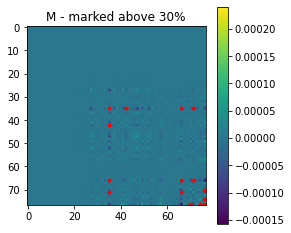

In [42]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_2c, fig_params)

## Train the GLR model (cntr: 3rd group)

In [43]:
# update the labels based on the 2nd group's response
data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
               'spike_data': group_responses_cntr[2], 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

_, train_lbls_3c = dh.update_set(train_data['smpls'], data_params)
_, val_lbls_3c = dh.update_set(val_data['smpls'], data_params)

In [44]:
val_lbls_3c

array([ 1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
        1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
       -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.])

In [45]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt': None, 'mu': 30,\
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time-balanced',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.7, \
                'num_its':150, 'check_freq':15, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# random parameter for edge selection and B initialization
seed = 0

# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_lbls_3c, sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)
print(len(sg_params['edges_tt']))

7975


In [46]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B_3c, fact_stats_3c = sg.fit_graph(train_data['des'], train_lbls_3c, sg_params, gd_opt_params, seed)
fact_M_3c = fact_B_3c.T @ fact_B_3c
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))

Number of training datapoints: 200
Number of features for each point: 77
mu = 30
   0: eps = 2.66e-02;  train loss (E) =  4.15
  15: eps = 4.64e-03;  train loss (E) =  0.05
  30: eps = 1.62e-03;  train loss (E) =  0.04
  45: eps = 1.13e-03;  train loss (E) =  0.04
  60: eps = 1.58e-03;  train loss (E) =  0.04
  75: eps = 2.21e-03;  train loss (E) =  0.04
  90: eps = 1.55e-03;  train loss (E) =  0.04
 105: eps = 2.16e-03;  train loss (E) =  0.04
 120: eps = 1.51e-03;  train loss (E) =  0.04
 135: eps = 1.06e-03;  train loss (E) =  0.04
 149: eps = 1.74e-03;  train loss (E) =  0.04
Elapsed  time: 47.512733 sec


In [47]:
# exp: 3rd model
fact_val_acc_3c, fact_y_est_3c, fact_t_3c = sg.get_acc(fact_M_3, train_data['des'], train_lbls_3c, 
                                                    val_data['des'], val_lbls_3c, sg_params, 'binary', 
                                                    seed, show_edges=False)
print('Elapsed time: {:.6f} sec'.format(fact_t_3c))
print('GLR val. acc. = {:.6f}'.format(fact_val_acc_3c))

Elapsed time: 0.123705 sec
GLR val. acc. = 0.680000


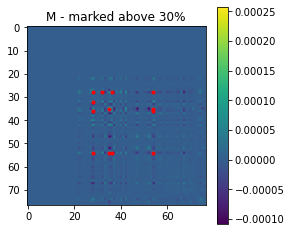

In [48]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
visualize_M(fact_M_3c, fig_params)

## Compare the control groups together

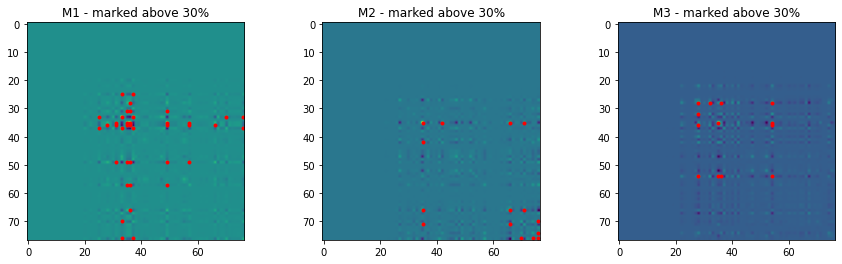

In [53]:
# print the optimized M
fig_params = {'rmark_th': 30, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}
rmark_th = fig_params['rmark_th']
xloc = fig_params['xloc']
yloc = fig_params['yloc']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(fact_M_1c)   
lim = (rmark_th/100) * np.max(fact_M_1c) # marker threshold                
plt.plot(xloc[fact_M_1c > lim],yloc[fact_M_1c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M1 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,2)
plt.imshow(fact_M_2c)
lim = (rmark_th/100) * np.max(fact_M_2c) # marker threshold                
plt.plot(xloc[fact_M_2c > lim],yloc[fact_M_2c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M2 - marked above {}%'.format(rmark_th))

plt.subplot(1,3,3)
plt.imshow(fact_M_3c)
lim = (rmark_th/100) * np.max(fact_M_3c) # marker threshold                
plt.plot(xloc[fact_M_3c > lim],yloc[fact_M_3c > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M3 - marked above {}%'.format(rmark_th))

plt.savefig('image/Ms_cntr.png',dpi=300, bbox_inches = "tight")

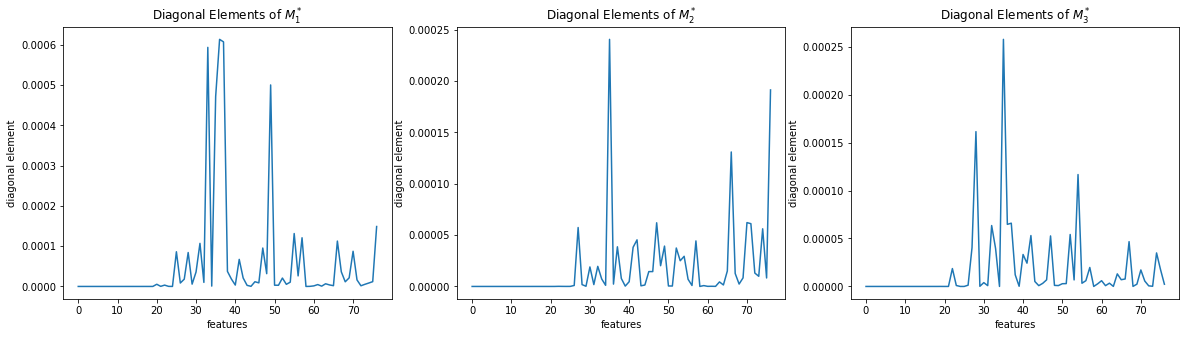

In [50]:
# print the diagonal elements of M
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(fact_M_1c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_1^*$')

plt.subplot(1,3,2)
plt.plot(fact_M_2c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_2^*$')

plt.subplot(1,3,3)
plt.plot(fact_M_3c.diagonal())
plt.xlabel('features')
plt.ylabel('diagonal element')
plt.title('Diagonal Elements of $M_3^*$')

plt.savefig('image/diagonals_cntr.png',dpi=300, bbox_inches = "tight")

The largest eigenvalues of M1:
 [3.50152072e-03 5.89090683e-04 8.76808021e-05 4.82330162e-05
 1.70796777e-05 6.06915929e-06 5.87327130e-09 4.47878141e-10
 1.73119452e-10 1.19224999e-11]
The largest eigenvalues of M2:
 [7.49958410e-04 4.48455335e-04 7.72677378e-05 5.92713246e-05
 2.20436244e-05 4.46190450e-06 8.38114427e-07 9.74329321e-08
 2.90459323e-10 1.70970189e-10]
The largest eigenvalues of M3:
 [8.18861285e-04 3.12921312e-04 9.18115077e-05 5.09626721e-05
 1.17161311e-05 6.67093031e-06 1.58566845e-06 3.34020592e-08
 1.26103444e-10 4.34684638e-11]


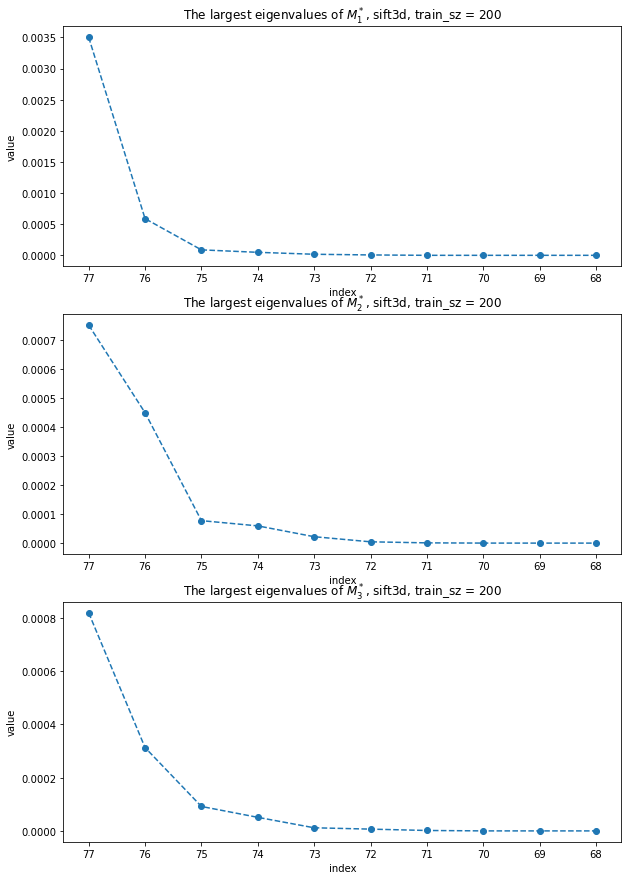

In [51]:
# print the eigenvalues
num_eig = 10
eigvals_1 = np.sort(np.real(np.linalg.eigvals(fact_M_1c)))
eigvals_2 = np.sort(np.real(np.linalg.eigvals(fact_M_2c)))
eigvals_3 = np.sort(np.real(np.linalg.eigvals(fact_M_3c)))

print('The largest eigenvalues of M1:\n', eigvals_1[-1:-num_eig-1:-1])
print('The largest eigenvalues of M2:\n', eigvals_2[-1:-num_eig-1:-1])
print('The largest eigenvalues of M3:\n', eigvals_3[-1:-num_eig-1:-1])

x = eigvals_1.shape[0] - np.arange(num_eig)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(np.arange(num_eig), np.real(eigvals_1[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_1^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,2)
plt.plot(np.arange(num_eig), np.real(eigvals_2[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_2^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.subplot(3,1,3)
plt.plot(np.arange(num_eig), np.real(eigvals_3[-1:-num_eig-1:-1]), marker='o', linestyle='--')
_ = plt.xticks(np.arange(num_eig), x)
plt.xlabel('index')
plt.ylabel('value')
plt.title('The largest eigenvalues of $M_3^*$, {}, train_sz = {}'.format(data_params['feature_id'], train_num))

plt.savefig('image/eigvals_cntr.png',dpi=300, bbox_inches = "tight")

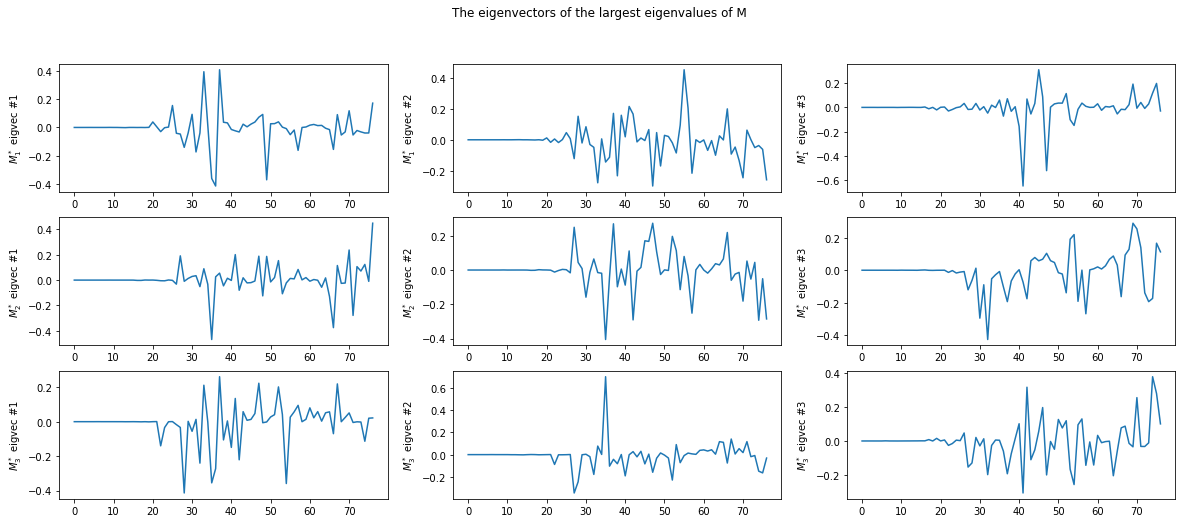

In [52]:
# plot the top eigenvectors for each cell group
num_eigvecs = 3
eigvals, eigvecs = np.linalg.eig(fact_M_1c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_1c = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_2c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_2c = eigvecs[: ,maxeig_ind]

eigvals, eigvecs = np.linalg.eig(fact_M_3c)
sorted_eigvals = sorted(list(zip(np.arange(eigvals.shape[0]), np.real(eigvals))), key = lambda x: x[1], reverse=True)
maxeig_ind = [ind for (ind, eigval) in sorted_eigvals[0:num_eigvecs]]
maxeig_vecs_3c = eigvecs[: ,maxeig_ind]

# plot the eigenvectors
xs = np.arange(maxeig_vecs_1c.shape[0])
plt.figure(figsize=(20,8))
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,i+1)
    plt.plot(xs, np.real(maxeig_vecs_1c[:,i]))
    plt.ylabel('$M_1^*$ eigvec #{}'.format(i+1))

for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_2c[:,i]))
    plt.ylabel('$M_2^*$ eigvec #{}'.format(i+1))
    
for i in range(num_eigvecs):
    plt.subplot(3,num_eigvecs,2*num_eigvecs+i+1)
    plt.plot(xs, np.real(maxeig_vecs_3c[:,i]))
    plt.ylabel('$M_3^*$ eigvec #{}'.format(i+1))
    
_ = plt.suptitle('The eigenvectors of the largest eigenvalues of M')
plt.savefig('image/eigvecs_cntr.png',dpi=300, bbox_inches = "tight")